# Init

In [1]:
sys.path.append(os.environ['DEV_AUTOTS'])
sys.path.append(os.environ['CAPSTONE_PYTHON_SOURCE'])
folder = os.environ['CAPSTONE_DATA']

In [2]:
import os
import glob
import sys
import math

# Data Tables
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# EDA and Feature Engineering
from scipy.spatial.distance import euclidean, pdist, squareform

# Auto Time Series
import auto_ts as AT

Running Auto Timeseries version: 0.0.22...Call by using:
        auto_ts.Auto_Timeseries(traindata, ts_column,
                            target, sep,  score_type='rmse', forecast_period=5,
                            time_interval='Month', non_seasonal_pdq=None, seasonality=False,
                            seasonal_period=12, seasonal_PDQ=None, model_type='stats',
                            verbose=1)
    To run three models from Stats, ML and FB Prophet, set model_type='best'
To remove previous versions, perform 'pip uninstall auto_ts'
To get the latest version, perform "pip install auto_ts --no-cache-dir --ignore-installed"


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from ETL.ETL import loadDataset, getTopProducts
from similarity.similarity import mergeTopSimilar, loadSimilarity
dataRaw= loadDataset(version=4)
dfSimilarity = loadSimilarity(version=4)

# Prep Data

In [5]:
#Parameters
ChainMaster = 'SPECS'
ProdCat='SUP PREM WHISKEY'
TOP_PRODUCTS = 5
TOP_SIMILAR = 1  # Get TOP_SIMILAR most similar products
ProductsList = getTopProducts(dataRaw,ChainMaster=ChainMaster,ProdCat=ProdCat,topN=TOP_PRODUCTS,timeCol='WeekDate')
ProductsList

['JACK DANIELS BLK WHSKY  1L',
 'JACK DANIELS BLK WHSKY  1.75L',
 'JACK DANIELS BLK WHSKY  750M',
 'BUFFALO TRACE BOURBON  1L',
 'WL WELLER BBN RSV  1.75L']

Decoder: {'0': 'JACK DANIELS BLK WHSKY  1L', '1': 'JACK DANIELS BLK WHSKY  1.75L', '2': 'JACK DANIELS BLK WHSKY  750M', '3': 'BUFFALO TRACE BOURBON  1L', '4': 'WL WELLER BBN RSV  1.75L'}



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------
Exogenous Price Columns: ['0', '1']
% of weeks without a purchase: 6.301369863013699


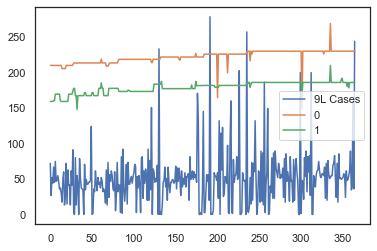




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------
Exogenous Price Columns: ['1', '0']
% of weeks without a purchase: 23.835616438356162


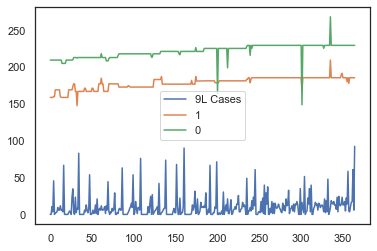




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  750M
--------------------------------------------------
Exogenous Price Columns: ['2', '1']
% of weeks without a purchase: 25.753424657534246


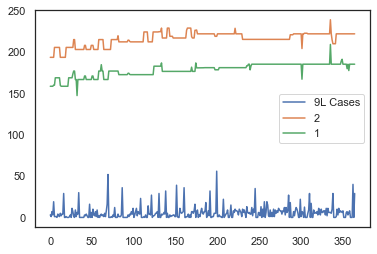




--------------------------------------------------
Product: BUFFALO TRACE BOURBON  1L
--------------------------------------------------
Exogenous Price Columns: ['3', '0']
% of weeks without a purchase: 81.36986301369863


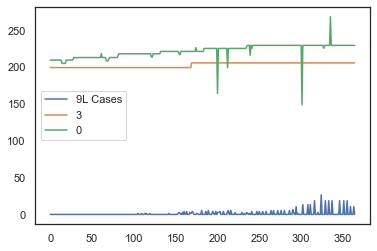




--------------------------------------------------
Product: WL WELLER BBN RSV  1.75L
--------------------------------------------------
Exogenous Price Columns: ['4', '0']
% of weeks without a purchase: 89.86301369863014


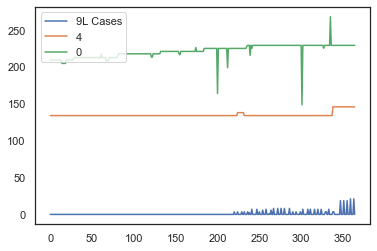

In [6]:
all_data = []

for i, Product in enumerate(ProductsList):
    # Product = ProductsList[0]
    colTime = 'WeekDate'
    colPreds = ['9L Cases'] #Demand
    colPrice = ['Dollar Sales per 9L Case'] #Price

    #TO DO:
    #Merge top similar only looking at a list of products  DONE
    #Encode before the merge? (same prods same code) DONE
    #one chain, top three products, top 1 similar DONE
    #Impute the price DONE
    (dataModel,colExog,colEnc,colDec) = mergeTopSimilar(dataRaw, dfSimilarity
                                                        ,ChainMaster=ChainMaster
                                                        ,Product=Product
                                                        ,ProductsList=ProductsList
                                                        ,topn=TOP_SIMILAR 
                                                        ,selCols = colPrice + colPreds,periodCol = colTime
                                                        ,pivotCol='Dollar Sales per 9L Case' 
                                                        ,encodeCols=True)
                                                                            
    
    if i == 0:
        print(f"Decoder: {colDec}")

    print("\n\n")
    print("-"*50)
    print(f"Product: {colDec.get(str(i))}")
    print("-"*50)
    
    #colExog = colExog + colEndog
    print(f"Exogenous Price Columns: {colExog}")
    
    allCols=[colTime]+colPreds+ colExog
    data=dataModel[allCols]
    print(f"% of weeks without a purchase: {sum(data['9L Cases'] == 0)/data.shape[0]*100}")
    # print(data.tail(5))
    data.iloc[:][data.columns[-(TOP_SIMILAR+2):]].plot()
    all_data.append(data)
    plt.show()

In [7]:
FORECAST_PERIOD = 4 # Pricing changes every 4 weeks
all_train = []
all_test = []
all_models = []

# Model

In [8]:
for i, data in enumerate(all_data):
    train = data.iloc[:-FORECAST_PERIOD]
    test = data.iloc[-FORECAST_PERIOD:]
    all_train.append(train)
    all_test.append(test)
    print(train.shape,test.shape)

    automl_model = AT.AutoTimeSeries(
        score_type='rmse', forecast_period=FORECAST_PERIOD, time_interval='Week',
        non_seasonal_pdq=None, seasonality=True, seasonal_period=12,
        model_type=['SARIMAX','ML'],
        verbose=0)
    automl_model.fit(train, 'WeekDate', '9L Cases', ',')
    automl_model.get_leaderboard()
    all_models.append(automl_model)

(361, 4) (4, 4)
Start of Fit.....
    Target variable = 9L Cases
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
    Dataframe loaded successfully. Shape of data set = (361, 3)
Time Interval is given as Week


Building SARIMAX Model



Running Seasonal SARIMAX Model...
Building a Seasonal Model...

    Finding best Non-Seasonal pdq Parameters:

Differencing = 0 with Seasonality = False
    Iteration 0 completed...
Inside find_best_pdq_or_PDQ --> results_bic
             MA0          MA1          MA2          MA3
AR0          NaN  3564.167313  3549.518810  3533.622982
AR1  3581.470838  3552.756155  3559.117341  3535.703785
AR2  3569.927177  3554.137320  3557.492282  3541.003401
AR3  3550.696894  3545.157376  3546.538178  3539.899371
    Best AR order p = 0, MA order q = 3, Interim metric = 3533.623

Differencing = 1 with Seasonality = True
Inside find_best_pdq_or_PDQ --> results_bic
     MA0  MA1  MA2  MA3
AR0  NaN  NaN  NaN  NaN
AR1  NaN  NaN  NaN  Na

In [14]:
for i in np.arange(len(all_data)):
    print("\n")
    print("-"*50)
    print(f"Product: {colDec.get(str(i))}")
    print("-"*50)
    print("\nLeaderboard")
    print(all_models[i].get_leaderboard())



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------

Leaderboard
      name       rmse
0  SARIMAX  14.397797
1       ML  22.443661


--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------

Leaderboard
      name       rmse
0  SARIMAX   6.007266
1       ML  15.173399


--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  750M
--------------------------------------------------

Leaderboard
      name      rmse
1       ML  4.034884
0  SARIMAX  6.463436


--------------------------------------------------
Product: BUFFALO TRACE BOURBON  1L
--------------------------------------------------

Leaderboard
      name      rmse
1       ML  2.776926
0  SARIMAX  7.340334


--------------------------------------------------
Product: WL WELLER BBN RSV  1.75L
---------------------------------------

# Prediction

In [15]:
for i, data in enumerate(all_data):
    print("\n")
    print("-"*50)
    print(f"Product: {colDec.get(str(i))}")
    print("-"*50)
    print("\nTest Data")
    print(all_test[i])
    test_predictions = all_models[i].predict(X_exogen = all_test[i])  
    print("\nBest Prediction")
    print(test_predictions)
    print("\nML Predictions")
    test_predictions = all_models[i].predict(X_exogen = all_test[i], model='ML')  
    print(test_predictions)
    print("\nSARIMAX Predictions")
    test_predictions = all_models[i].predict(X_exogen = all_test[i], model='SARIMAX')  
    print(test_predictions)



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------

Test Data
      WeekDate  9L Cases           0           1
361 2019-12-05     37.24  229.533835  185.589744
362 2019-12-12    159.60  229.533835  185.589744
363 2019-12-19     35.91  229.533835  185.589744
364 2019-12-26    243.39  229.533835  185.589744

Best Prediction
2019-12-05    49.733381
2019-12-12    41.734190
2019-12-19    53.236695
2019-12-26    57.775902
Freq: W-THU, Name: mean, dtype: float64

ML Predictions
361    49.147833
362    49.184540
363    49.189943
364    49.190117
Name: mean, dtype: float64

SARIMAX Predictions
2019-12-05    49.733381
2019-12-12    41.734190
2019-12-19    53.236695
2019-12-26    57.775902
Freq: W-THU, Name: mean, dtype: float64


--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------

Test Data
      WeekDate  9L Cases     